In [1]:
from src.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
import pandas as pd

from scipy.stats import norm, gaussian_kde

import os

%matplotlib inline

In [2]:
device = "cuda:5"

In [3]:
def gen_data(int):
    theta1 = torch.randn(int) * 3
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return torch.stack([theta1, x1, x2])

In [4]:
data = gen_data(10_000)
val_data = gen_data(1000)
nodes_max = data.shape[0]
node_ids = torch.arange(nodes_max)

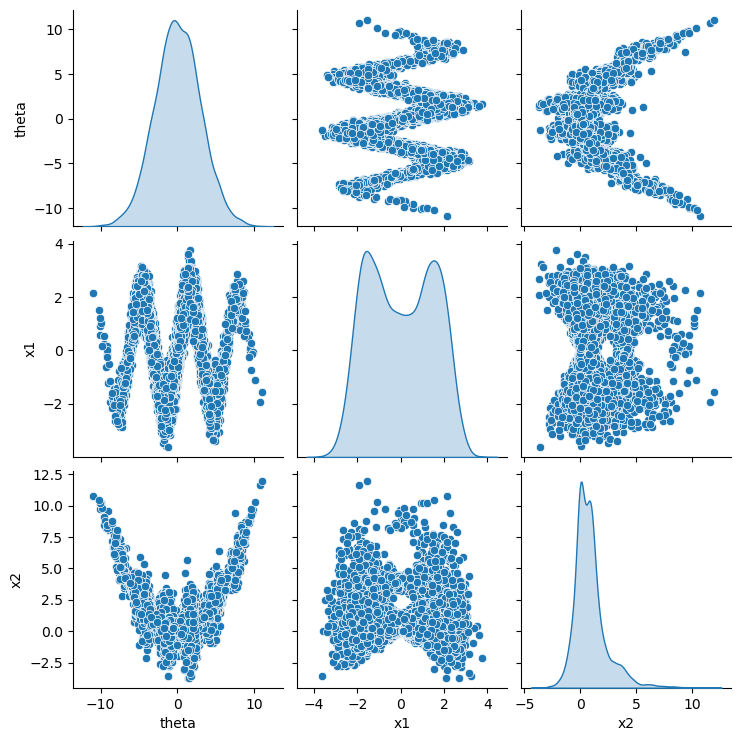

In [5]:
df = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
sns.pairplot(df, diag_kind='kde')
plt.show()

In [6]:
model = ModelTransfuser(data.T.shape[1], depth=4, num_heads=4, sigma=5, hidden_size=64)

In [7]:
model.train(data.T, val_data=val_data.T, epochs=50, verbose=False, device=device)

Training finished after 1.9 minutes


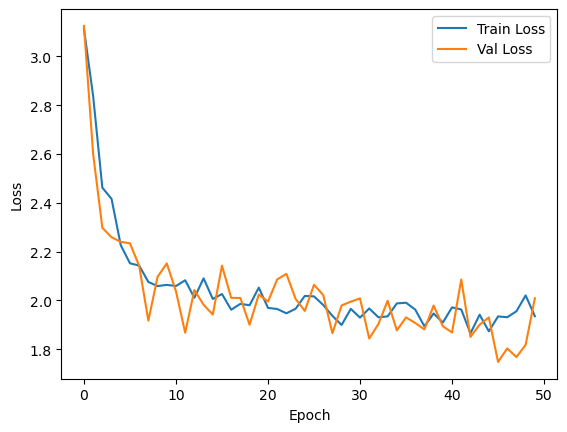

In [8]:
epoch = np.arange(0, len(model.train_loss))

plt.plot(epoch, np.array(model.train_loss)/data.shape[1], label='Train Loss')
plt.plot(epoch, np.array(model.val_loss)/val_data.shape[1], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
condition_mask = torch.zeros(nodes_max)

In [25]:
s = model.sample(data=torch.zeros(30,3), condition_mask=condition_mask, num_samples=1000, device=device, temperature=2.4)

100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


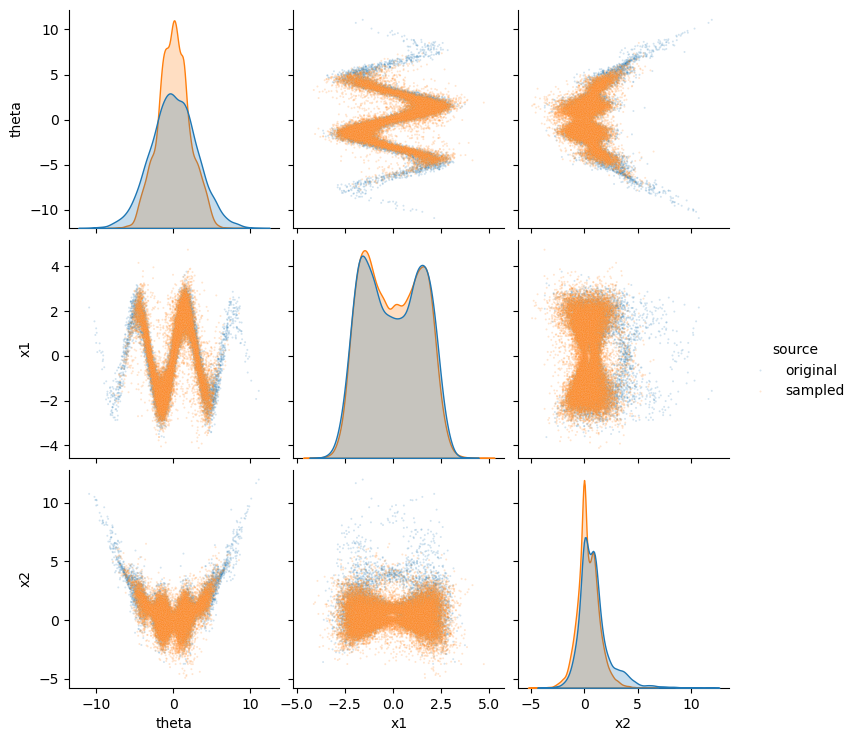

In [26]:
df_og = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
df = pd.DataFrame(s.permute(2,1,0).flatten(1).T.cpu().numpy(), columns=['theta', 'x1', 'x2'])

df_og['source'] = 'original'
df['source'] = 'sampled'

df_combined = pd.concat([df_og, df], axis=0)

sns.pairplot(df_combined, hue='source', diag_kind='kde', diag_kws=dict(common_norm=False), plot_kws=dict(alpha=0.2, s=2))
#df12 = pd.concat([df_og, df], axis=0)
#sns.pairplot(df_og, diag_kind='kde')
#sns.pairplot(df, diag_kind='kde')
plt.show()

In [12]:
posterior=gaussian_kde(s.permute(2,1,0).flatten(1).cpu().numpy()[:2])

In [13]:
# 3d plot of the posterior
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([posterior([x, y]) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()


KeyboardInterrupt: 